In [1]:
!pip install timm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.2 MB/s eta 0:00:00


In [2]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

ROOT  = "/kaggle/working/eurosat"     # dataset cache
IMG_SIZE = 224
BATCH = 64
EPOCHS = 1            # set to 5–10 for >98 % accuracy

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# ↓ download EuroSAT RGB (27 k images, 270 MB)
full_ds = datasets.EuroSAT(ROOT, download=True, transform=tfm)
n = len(full_ds)
train_ds, val_ds, test_ds = random_split(full_ds,
        [int(0.8*n), int(0.1*n), n - int(0.9*n)])

train_ld = DataLoader(train_ds, BATCH, shuffle=True)
val_ld   = DataLoader(val_ds,   BATCH)
test_ld  = DataLoader(test_ds,  BATCH)

print(f"Dataset sizes  train:{len(train_ds)}  val:{len(val_ds)}  test:{len(test_ds)}")

100%|██████████| 94.3M/94.3M [00:00<00:00, 276MB/s]


Dataset sizes  train:21600  val:2700  test:2700


In [3]:
import timm
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=len(full_ds.classes)   # 10
).to(device)

# freeze everything except classification head for quick fine-tune
for name, p in model.named_parameters():
    if "head" not in name:
        p.requires_grad_(False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4)

Device: cuda


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [4]:
import timm, torch, torch.nn as nn, numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ViT-Base, ImageNet pretrained
model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=len(full_ds.classes)   # 10 classes
).to(device)

# 🔓 UNFREEZED **all** parameters for full fine-tuning
for p in model.parameters():
    p.requires_grad = True            # training the whole network

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)  # lower LR for full FT

Device: cuda


In [5]:
from tqdm.auto import tqdm
from torch.cuda.amp import autocast, GradScaler   # older import works everywhere
import time

EPOCHS = 7
PATIENCE = 2
BATCHES  = len(train_ld)

# Optimizer + One-Cycle LR
max_lr   = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=max_lr, epochs=EPOCHS, steps_per_epoch=BATCHES,
    pct_start=0.1)

scaler = GradScaler()   # no kwargs

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []
stop_counter = 0; best_val = 0

def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    bar = tqdm(loader, leave=False, desc="Train" if train else "Val")

    for x, y in bar:
        x, y = x.to(device), y.to(device)

        with autocast():
            logits = model(x)
            loss   = criterion(logits, y)

        if train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

        bs = y.size(0)
        total   += bs
        correct += (logits.argmax(1) == y).sum().item()
        loss_sum+= loss.item() * bs

        bar.set_postfix(
            acc=f"{correct/total:.4f}",
            lr=f"{scheduler.get_last_lr()[0]:.1e}")

    return loss_sum/total, correct/total

for ep in range(1, EPOCHS+1):
    print(f"\nEpoch {ep}/{EPOCHS}")
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_ld, train=True)
    val_loss, val_acc = run_epoch(val_ld, train=False)

    train_loss_hist.append(tr_loss); val_loss_hist.append(val_loss)
    train_acc_hist.append(tr_acc);   val_acc_hist.append(val_acc)

    print(f"train acc {tr_acc:.4f} | val acc {val_acc:.4f} "
          f"| val loss {val_loss:.4f} | time {time.time()-t0:.1f}s")

    if val_acc > best_val: best_val = val_acc
    if val_acc >= 0.993:
        stop_counter += 1
        if stop_counter >= PATIENCE:
            print("Early stopping – validation accuracy ≥99.3 % achieved.")
            break
    else:
        stop_counter = 0


Epoch 1/7


/tmp/ipykernel_19/84466099.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()   # no kwargs


Train:   0%|          | 0/338 [00:00<?, ?it/s]

/tmp/ipykernel_19/84466099.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Val:   0%|          | 0/43 [00:00<?, ?it/s]

train acc 0.8968 | val acc 0.9659 | val loss 0.1029 | time 221.0s

Epoch 2/7


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

train acc 0.9691 | val acc 0.9659 | val loss 0.1011 | time 232.5s

Epoch 3/7


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

train acc 0.9838 | val acc 0.9719 | val loss 0.0848 | time 228.8s

Epoch 4/7


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

train acc 0.9927 | val acc 0.9844 | val loss 0.0480 | time 226.3s

Epoch 5/7


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

train acc 0.9975 | val acc 0.9881 | val loss 0.0526 | time 222.6s

Epoch 6/7


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

train acc 0.9999 | val acc 0.9893 | val loss 0.0474 | time 217.5s

Epoch 7/7


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

train acc 1.0000 | val acc 0.9889 | val loss 0.0476 | time 219.2s


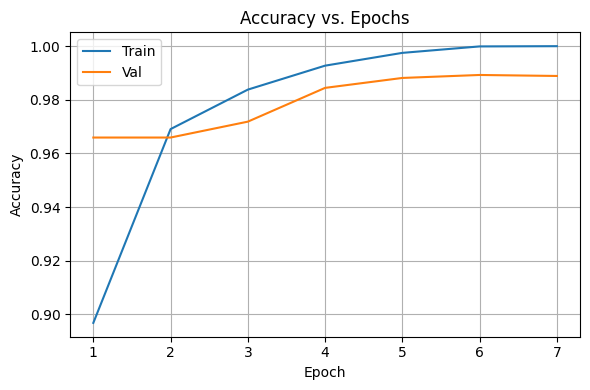

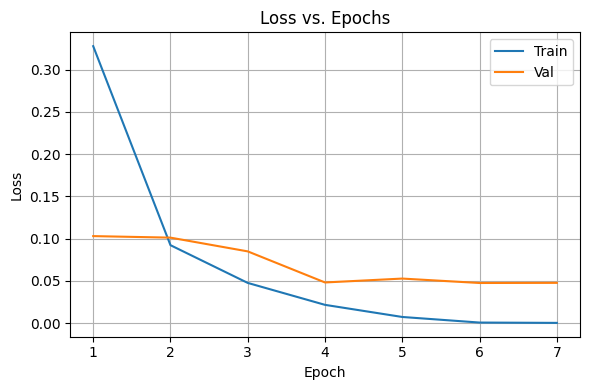

In [6]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_acc_hist)+1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc_hist, label="Train")
plt.plot(epochs, val_acc_hist,   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid()
plt.title("Accuracy vs. Epochs")
plt.tight_layout(); plt.savefig("acc_curve.png"); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss_hist, label="Train")
plt.plot(epochs, val_loss_hist,   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid()
plt.title("Loss vs. Epochs")
plt.tight_layout(); plt.savefig("loss_curve.png"); plt.show()

Test accuracy: 98.70%


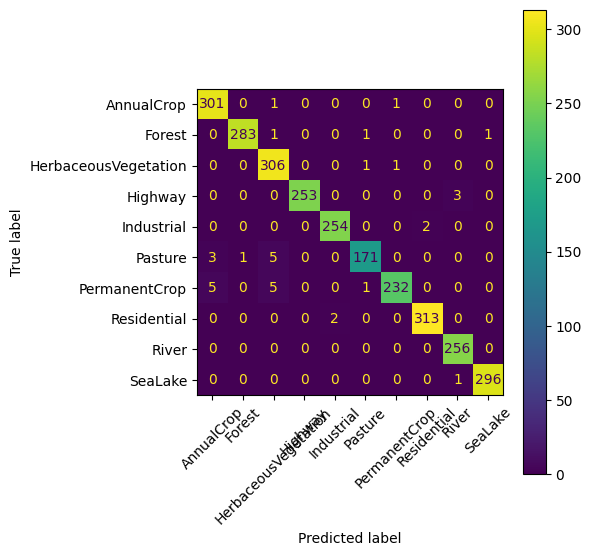

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval(); preds, labels = [], []
with torch.no_grad():
    for x,y in test_ld:
        preds.extend(model(x.to(device)).argmax(1).cpu().numpy())
        labels.extend(y.numpy())

test_acc = np.mean(np.array(preds)==np.array(labels))
print(f"Test accuracy: {test_acc*100:.2f}%")          # expect ~99 %

cm = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(cm, display_labels=full_ds.classes)
disp.plot(ax=ax, xticks_rotation=45); plt.tight_layout()
fig.savefig("eurosat_confusion.png"); plt.show()

In [8]:
torch.save(model.state_dict(), "vit_eurosat.pth")
print("Saved vit_eurosat.pth, acc_curve.png, loss_curve.png, eurosat_confusion.png")

Saved vit_eurosat.pth, acc_curve.png, loss_curve.png, eurosat_confusion.png


In [9]:
# ── Head-only baseline (freeze backbone, train head 1 epoch) ────────────
import copy, torch
from tqdm.auto import tqdm

# fresh ViT-Base
model_head = timm.create_model(
    "vit_base_patch16_224", pretrained=True,
    num_classes=len(full_ds.classes)
).to(device)

# freeze backbone
for name, p in model_head.named_parameters():
    if "head" not in name:
        p.requires_grad_(False)

optimizer_head = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_head.parameters()),
    lr=1e-4)

criterion = nn.CrossEntropyLoss()

def train_one_epoch_head():
    model_head.train()
    for x, y in tqdm(train_ld, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer_head.zero_grad()
        logits = model_head(x)
        loss   = criterion(logits, y)
        loss.backward()
        optimizer_head.step()

def evaluate(loader):
    model_head.eval(); correct = 0; total = 0
    with torch.no_grad():
        for x, y in loader:
            preds = model_head(x.to(device)).argmax(1).cpu()
            correct += (preds == y).sum().item()
            total   += y.size(0)
    return correct / total

# run 1 epoch head-only
train_one_epoch_head()
val_acc_head = evaluate(val_ld)
print(f"Head-only ViT-Base 1-epoch validation accuracy: {val_acc_head*100:.2f}%")

  0%|          | 0/338 [00:00<?, ?it/s]

Head-only ViT-Base 1-epoch validation accuracy: 87.26%


In [10]:
!pip install torchcam --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00


In [11]:
!pip install captum --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.0 MB/s eta 0:00:00


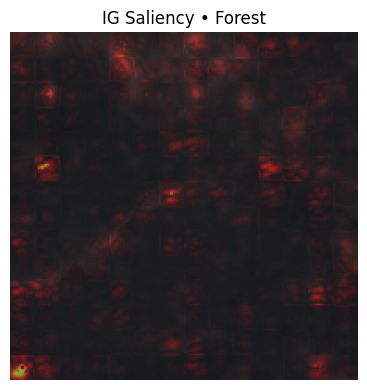

Saved saliency_overlay.png


In [12]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt, numpy as np, torch, random
from torchvision.transforms.functional import resize

ig = IntegratedGradients(model)

# random test sample
idx = random.randint(0, len(test_ds)-1)
img, label = test_ds[idx]
inp = img.unsqueeze(0).to(device).requires_grad_(True)

model.eval()
pred = model(inp).argmax(1).item()

# integrated gradients attribution
attr = ig.attribute(inp, target=pred, n_steps=50).abs().sum(dim=1)[0].cpu()
attr = (attr - attr.min()) / (attr.max() - attr.min())

# upscale & overlay
attr_up = resize(attr.unsqueeze(0), [224,224]).squeeze().detach().numpy()

plt.figure(figsize=(4,4))
plt.imshow(np.transpose(img.numpy(), (1,2,0)))
plt.imshow(attr_up, alpha=0.5, cmap='hot')
plt.title(f"IG Saliency • {full_ds.classes[label]}")
plt.axis('off')
plt.tight_layout(); plt.savefig("saliency_overlay.png"); plt.show()
print("Saved saliency_overlay.png")

In [13]:
# ── Tiny-ViT baseline: full fine-tune for 6 epochs ───────────────────────
import timm, torch, time
from tqdm.auto import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

tiny = timm.create_model(
    "vit_tiny_patch16_224",
    pretrained=True,
    num_classes=len(full_ds.classes)
).to(device)

# unfreeze everything
for p in tiny.parameters():
    p.requires_grad = True

optimizer_tiny = torch.optim.AdamW(tiny.parameters(), lr=5e-5, weight_decay=5e-2)
criterion = nn.CrossEntropyLoss()

EPOCHS_TINY = 6
print(f"Tiny-ViT params: {sum(p.numel() for p in tiny.parameters())/1e6:.1f} M")

def run_epoch_tiny(loader, train=False):
    tiny.train(train)
    correct = total = 0
    bar = tqdm(loader, leave=False, desc="Train" if train else "Val")
    for x, y in bar:
        x, y = x.to(device), y.to(device)
        if train:
            optimizer_tiny.zero_grad()
            logits = tiny(x); loss = criterion(logits, y)
            loss.backward(); optimizer_tiny.step()
        else:
            with torch.no_grad():
                logits = tiny(x)
        correct += (logits.argmax(1) == y).sum().item()
        total   += y.size(0)
        bar.set_postfix(acc=f"{correct/total:.4f}")
    return correct/total

best_val = 0
for ep in range(1, EPOCHS_TINY+1):
    t0 = time.time()
    run_epoch_tiny(train_ld, train=True)
    val_acc = run_epoch_tiny(val_ld)
    best_val = max(best_val, val_acc)
    print(f"Epoch {ep}/{EPOCHS_TINY}  val acc {val_acc:.4f}  time {time.time()-t0:.1f}s")

print(f"\nTiny-ViT best validation accuracy: {best_val*100:.2f}%")
torch.save(tiny.state_dict(), "vit_tiny_eurosat.pth")
print("Saved vit_tiny_eurosat.pth")

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Tiny-ViT params: 5.5 M


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1/6  val acc 0.9707  time 114.7s


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 2/6  val acc 0.9778  time 114.3s


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 3/6  val acc 0.9774  time 113.9s


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 4/6  val acc 0.9844  time 114.2s


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 5/6  val acc 0.9700  time 114.1s


Train:   0%|          | 0/338 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 6/6  val acc 0.9744  time 114.0s

Tiny-ViT best validation accuracy: 98.44%
Saved vit_tiny_eurosat.pth
